<a href="https://colab.research.google.com/github/agarr3/vajra/blob/master/LSTM_AUTO_ENCODER_Indian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Just Like that test code -


In [1]:
import torch
import torch.nn as nn

input_dim = 5
hidden_dim = 10
n_layers = 1

lstm_layer = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

batch_size = 2
seq_len = 3

inp = torch.randn(batch_size, seq_len, input_dim)
hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
cell_state = torch.randn(n_layers, batch_size, hidden_dim)
hidden = (hidden_state, cell_state)

out, hidden = lstm_layer(inp, hidden)
print("Output shape: ", out.shape)
print("Hidden: ", hidden[1].shape)
print(hidden[1].repeat(inp.shape).shape)
print(hidden[1].repeat(inp.shape).shape[0])

Output shape:  torch.Size([2, 3, 10])
Hidden:  torch.Size([1, 2, 10])
torch.Size([2, 6, 50])
2


Start of the code. Mount Western dataset

In [2]:
import torch

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import numpy as np

import os
files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk("/content/drive/My Drive/Indian_numpy"):
  for file in fileList:
    if(True):
      files.append(os.path.join(r,file))
    else:
      print(file)

    
    # dimension = np.load(os.path.join(r,file),  mmap_mode='r')
    # if(dimension.shape == (26,400)):
    #   files.append(os.path.join(r,file))
    # else:
    #   print(file)

(len(files))

Mounted at /content/drive


2008

In [3]:
(len(files))

2008

COnfiguration for Auto encoder

In [4]:
class configeration:
  seq_len = 200
  input_dim = 26
  embedding_dim = 64
  batch_size = 2
  base_dir = "/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MEL/Indian"
  loss_function = torch.nn.MSELoss(reduction='sum')
  lr=1e-3
  n_epochs = 90
  model_file = "/models/mel.pkl"
  results_dir = os.path.join(base_dir, "./results")
  checkpoint_model_file = "/models/mel_checkpoint.pkl"

Start of auto encoder for MEL

In [5]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    #x = x.reshape((1, self.seq_len, self.n_features))
    #print(x.shape)
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return x

In [6]:
class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    #print("in decoder", x.shape)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

In [7]:
class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [8]:
x = torch.randn(5, 26, 400)
print(x.shape)
x = x.permute(0, 2, 1)
print(x.shape)

encoder = Encoder(400, 26, 64)
encoded = encoder(x)
print(encoded.shape)

decoder = Decoder(400, 64, 26)
decoded = decoder(encoded)
print(decoded.shape)

rae = RecurrentAutoencoder(400, 26, 64)
output = rae(x)

print(output.shape)

torch.Size([5, 26, 400])
torch.Size([5, 400, 26])
torch.Size([5, 400, 64])
torch.Size([5, 400, 26])
torch.Size([5, 400, 26])


In [10]:
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SequentialSampler

class CustomDatasetMel(Dataset):

    def __init__(self, dataList, labelList):
        self.data = dataList
        self.labels = labelList

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        import numpy as np
        fileName = self.data[index]
        
        mel_spect = np.load(fileName)
        data = torch.tensor(mel_spect[:,:200], dtype=torch.float)
        data = data.permute(1, 0)
        #data = torch.unsqueeze(data, dim =0)

        label = torch.tensor(self.labels[index])
        return data, label

class CustomDatasetMNIST(Dataset):

    def __init__(self, dataDF):
        self.data = dataDF
        
    def __len__(self):
        return len(self.data.index)

    def __getitem__(self, index):
        import numpy as np
        
        data = self.data.iloc[index][1:].tolist()
        data = torch.tensor(data, dtype=torch.float)
        data = data.view(28,28)

        label = self.data.iloc[index][0]
        label = torch.tensor(label)
        return data, label

In [11]:
import torchvision
import torch

from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SequentialSampler

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

def load_mnist(path='/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST/data', download=False, batch_size=100, shift_pixels=2):
        """
        Construct dataloaders for training and test data. Data augmentation is also done here.
        :param path: file path of the dataset
        :param download: whether to download the original data
        :param batch_size: batch size
        :param shift_pixels: maximum number of pixels to shift in each direction
        :return: train_loader, test_loader
        """
        kwargs = {'num_workers': 1, 'pin_memory': True}

        train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(path, train=True, download=download,
                           transform=transforms.Compose([transforms.RandomCrop(size=28, padding=shift_pixels),
                                                         transforms.ToTensor()])),
            batch_size=batch_size, shuffle=True, **kwargs)
        test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(path, train=False, download=download,
                           transform=transforms.ToTensor()),
            batch_size=batch_size, shuffle=True, **kwargs)

        return train_loader, test_loader

train_loader, test_loader = load_mnist(download=False)


# path='/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST/data'
# mnist = datasets.MNIST(path, train=True, download=False,
#                            transform=transforms.Compose([transforms.RandomCrop(size=28, padding=2),
#                                                          transforms.ToTensor()]))

# print(mnist.__getitem__(1)[0].shape)

import pandas as pd
train_df = pd.read_csv("/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST/data/MNIST/mnist_train.csv")
print(train_df.iloc[0][1:].tolist())

import numpy as np 
from PIL import Image

# array = np.array(train_df.iloc[0][1:].tolist())

# array = np.reshape(array, (28, 28))
# print(array)
# data = Image.fromarray(np.uint8(array)).convert('RGB')
# data

train_df.iloc[0]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 18, 18, 18, 126, 136, 175, 26, 166, 255, 247, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 36, 94, 154, 170, 253, 253, 253, 253, 253, 225, 172, 253, 242, 195, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 238, 253, 253, 253, 253, 253, 253, 253, 253, 251, 93, 82, 82, 56, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 219, 253, 253, 253, 253, 253, 198, 182, 247, 241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 156, 107, 253, 253, 205, 11, 0, 43, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 1, 154, 253, 90, 0, 

label    5
1x1      0
1x2      0
1x3      0
1x4      0
        ..
28x24    0
28x25    0
28x26    0
28x27    0
28x28    0
Name: 0, Length: 785, dtype: int64

in training loop, epoch 18, step 689, the loss is 98620.015625
in training loop, epoch 18, step 690, the loss is 58396.4453125
in training loop, epoch 18, step 691, the loss is 86918.046875
in training loop, epoch 18, step 692, the loss is 93086.3046875
in training loop, epoch 18, step 693, the loss is 120921.4453125
in training loop, epoch 18, step 694, the loss is 123645.859375
in training loop, epoch 18, step 695, the loss is 95601.3359375
in training loop, epoch 18, step 696, the loss is 84951.765625
in training loop, epoch 18, step 697, the loss is 79334.1015625
in training loop, epoch 18, step 698, the loss is 69973.515625
in training loop, epoch 18, step 699, the loss is 77325.4453125
in training loop, epoch 18, step 700, the loss is 69242.828125
in training loop, epoch 18, step 701, the loss is 82456.375
in training loop, epoch 18, step 702, the loss is 154284.03125
in training loop, epoch 18, step 703, the loss is 76354.8828125
in training loop, epoch 18, step 704, the loss is

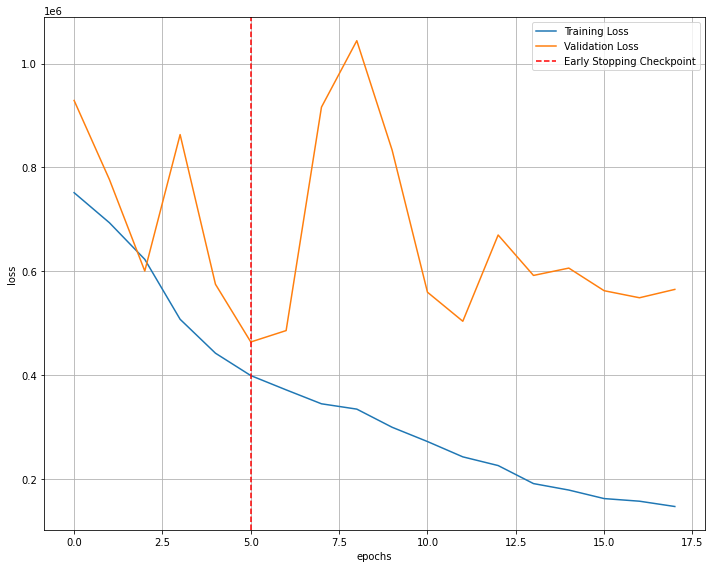

Epoch 18: train loss 146712.0801053598 val loss 564933.0505244647
in training loop, epoch 19, step 0, the loss is 208723.6875
in training loop, epoch 19, step 1, the loss is 106359.625
in training loop, epoch 19, step 2, the loss is 91231.140625
in training loop, epoch 19, step 3, the loss is 123412.7265625
in training loop, epoch 19, step 4, the loss is 107905.828125
in training loop, epoch 19, step 5, the loss is 143921.734375
in training loop, epoch 19, step 6, the loss is 118497.0234375
in training loop, epoch 19, step 7, the loss is 143005.328125
in training loop, epoch 19, step 8, the loss is 92937.5
in training loop, epoch 19, step 9, the loss is 77387.1171875
in training loop, epoch 19, step 10, the loss is 81394.0859375
in training loop, epoch 19, step 11, the loss is 111928.0234375
in training loop, epoch 19, step 12, the loss is 120564.59375
in training loop, epoch 19, step 13, the loss is 181983.46875
in training loop, epoch 19, step 14, the loss is 301909.875
in training l

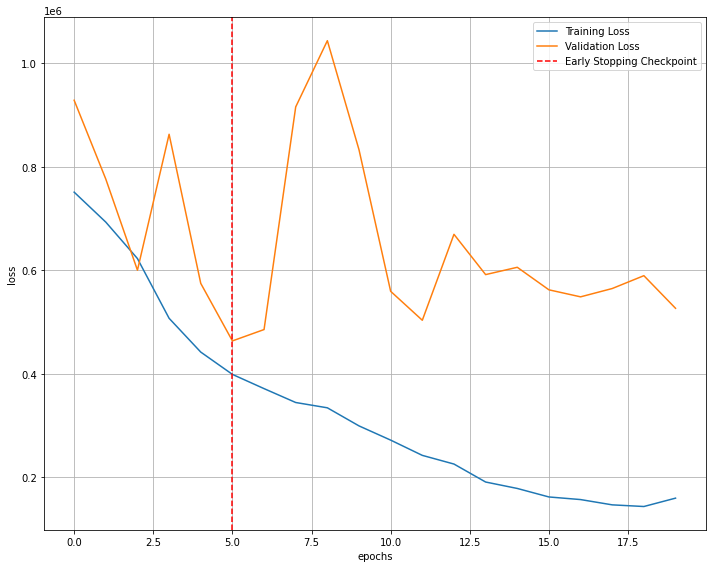

Epoch 20: train loss 159683.44654195718 val loss 526695.6794462774
in training loop, epoch 21, step 0, the loss is 96037.1796875
in training loop, epoch 21, step 1, the loss is 99843.9296875
in training loop, epoch 21, step 2, the loss is 156109.75
in training loop, epoch 21, step 3, the loss is 156321.75
in training loop, epoch 21, step 4, the loss is 160075.5
in training loop, epoch 21, step 5, the loss is 195877.09375
in training loop, epoch 21, step 6, the loss is 117102.0
in training loop, epoch 21, step 7, the loss is 196392.90625
in training loop, epoch 21, step 8, the loss is 144353.4375
in training loop, epoch 21, step 9, the loss is 162893.15625
in training loop, epoch 21, step 10, the loss is 267653.8125
in training loop, epoch 21, step 11, the loss is 177563.65625
in training loop, epoch 21, step 12, the loss is 65805.921875
in training loop, epoch 21, step 13, the loss is 101019.0
in training loop, epoch 21, step 14, the loss is 105953.71875
in training loop, epoch 21, ste

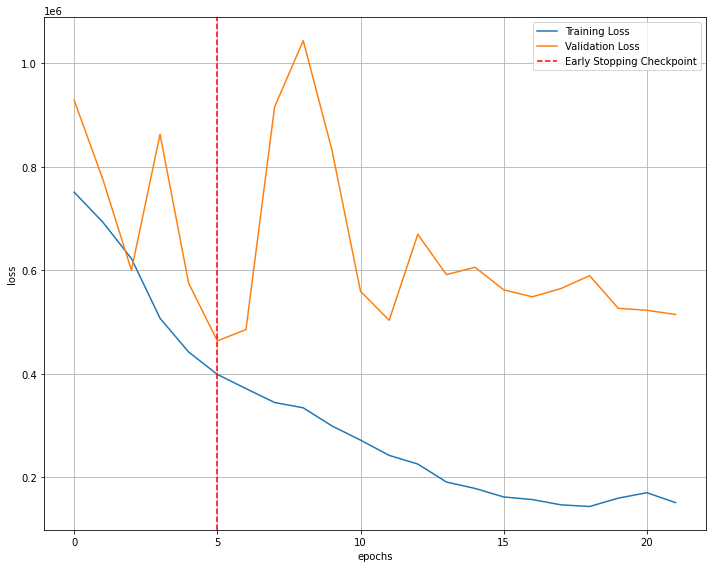

Epoch 22: train loss 150973.42986647162 val loss 514720.7787482881
in training loop, epoch 23, step 0, the loss is 91495.640625
in training loop, epoch 23, step 1, the loss is 87346.4921875
in training loop, epoch 23, step 2, the loss is 131931.1875
in training loop, epoch 23, step 3, the loss is 144925.828125
in training loop, epoch 23, step 4, the loss is 111420.5546875
in training loop, epoch 23, step 5, the loss is 246132.625
in training loop, epoch 23, step 6, the loss is 154544.9375
in training loop, epoch 23, step 7, the loss is 223423.890625
in training loop, epoch 23, step 8, the loss is 160862.25
in training loop, epoch 23, step 9, the loss is 178372.5625
in training loop, epoch 23, step 10, the loss is 145128.59375
in training loop, epoch 23, step 11, the loss is 137568.71875
in training loop, epoch 23, step 12, the loss is 89829.734375
in training loop, epoch 23, step 13, the loss is 76161.625
in training loop, epoch 23, step 14, the loss is 110571.109375
in training loop, 

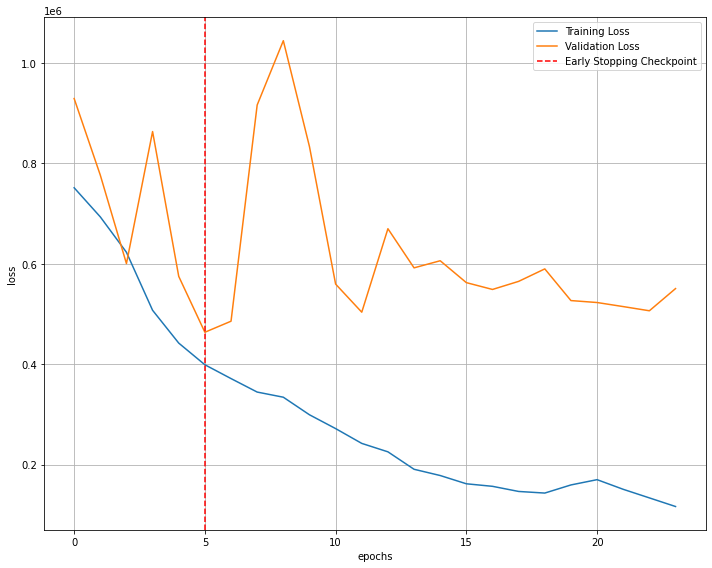

Epoch 24: train loss 116745.81397262512 val loss 550559.4528098543
in training loop, epoch 25, step 0, the loss is 158663.171875
in training loop, epoch 25, step 1, the loss is 159262.3125
in training loop, epoch 25, step 2, the loss is 115144.859375
in training loop, epoch 25, step 3, the loss is 89226.8828125
in training loop, epoch 25, step 4, the loss is 80431.2421875
in training loop, epoch 25, step 5, the loss is 107790.78125
in training loop, epoch 25, step 6, the loss is 78591.921875
in training loop, epoch 25, step 7, the loss is 105330.0859375
in training loop, epoch 25, step 8, the loss is 98697.3125
in training loop, epoch 25, step 9, the loss is 101051.953125
in training loop, epoch 25, step 10, the loss is 87538.109375
in training loop, epoch 25, step 11, the loss is 135836.15625
in training loop, epoch 25, step 12, the loss is 122263.2421875
in training loop, epoch 25, step 13, the loss is 72486.9375
in training loop, epoch 25, step 14, the loss is 108990.859375
in train

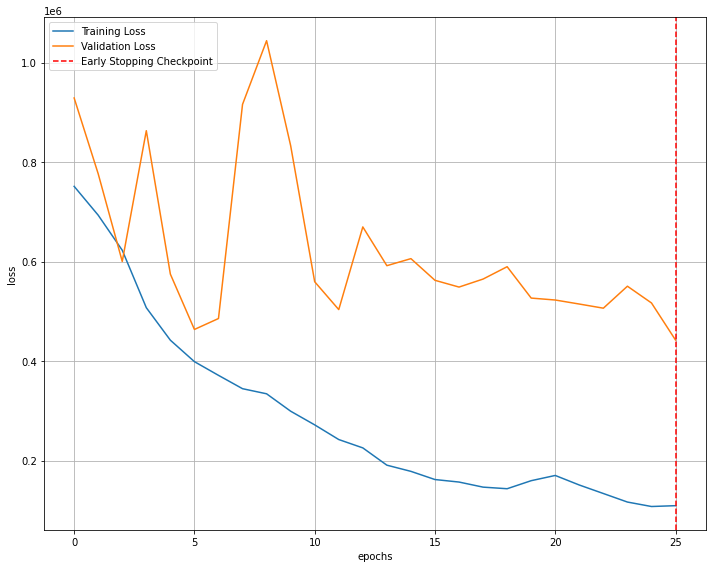

Epoch 26: train loss 109447.4389804065 val loss 442383.207037086
in training loop, epoch 27, step 0, the loss is 79588.5390625
in training loop, epoch 27, step 1, the loss is 43527.4140625
in training loop, epoch 27, step 2, the loss is 41178.80078125
in training loop, epoch 27, step 3, the loss is 91162.703125
in training loop, epoch 27, step 4, the loss is 43513.84375
in training loop, epoch 27, step 5, the loss is 88435.25
in training loop, epoch 27, step 6, the loss is 69848.8359375
in training loop, epoch 27, step 7, the loss is 131363.21875
in training loop, epoch 27, step 8, the loss is 167930.53125
in training loop, epoch 27, step 9, the loss is 119018.0625
in training loop, epoch 27, step 10, the loss is 79155.0
in training loop, epoch 27, step 11, the loss is 75452.2578125
in training loop, epoch 27, step 12, the loss is 91482.390625
in training loop, epoch 27, step 13, the loss is 67295.515625
in training loop, epoch 27, step 14, the loss is 84574.5859375
in training loop, e

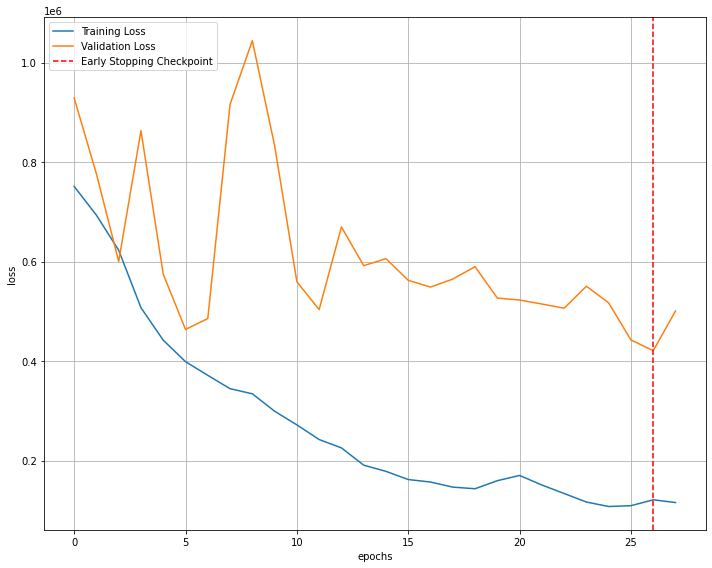

Epoch 28: train loss 115707.41347306088 val loss 500862.37920777826
in training loop, epoch 29, step 0, the loss is 103542.65625
in training loop, epoch 29, step 1, the loss is 105707.546875
in training loop, epoch 29, step 2, the loss is 56805.6796875
in training loop, epoch 29, step 3, the loss is 118498.234375
in training loop, epoch 29, step 4, the loss is 69102.296875
in training loop, epoch 29, step 5, the loss is 107260.2421875
in training loop, epoch 29, step 6, the loss is 48517.6953125
in training loop, epoch 29, step 7, the loss is 67647.0
in training loop, epoch 29, step 8, the loss is 77975.34375
in training loop, epoch 29, step 9, the loss is 61005.46484375
in training loop, epoch 29, step 10, the loss is 105596.984375
in training loop, epoch 29, step 11, the loss is 53994.1171875
in training loop, epoch 29, step 12, the loss is 86400.1875
in training loop, epoch 29, step 13, the loss is 81697.640625
in training loop, epoch 29, step 14, the loss is 51554.9296875
in traini

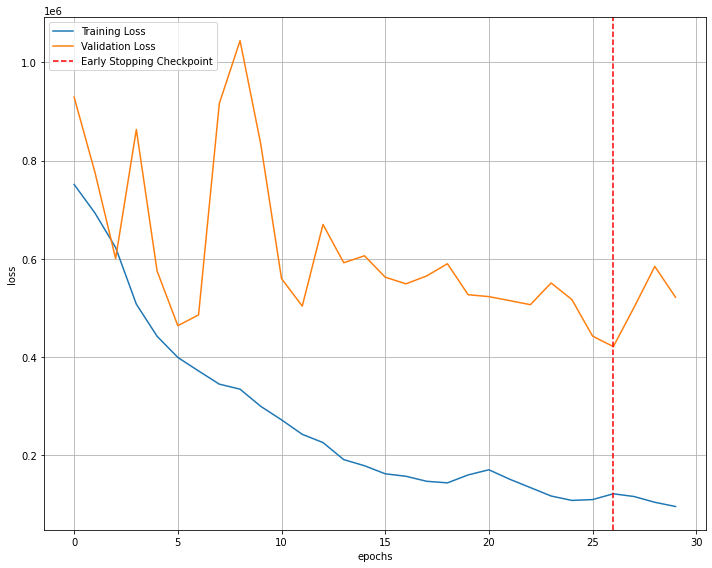

Epoch 30: train loss 95359.65921470369 val loss 521542.7248544883
in training loop, epoch 31, step 0, the loss is 52578.1875
in training loop, epoch 31, step 1, the loss is 58744.76171875
in training loop, epoch 31, step 2, the loss is 72895.9140625
in training loop, epoch 31, step 3, the loss is 99189.71875
in training loop, epoch 31, step 4, the loss is 53858.3125
in training loop, epoch 31, step 5, the loss is 150244.9375
in training loop, epoch 31, step 6, the loss is 73349.5625
in training loop, epoch 31, step 7, the loss is 123814.703125
in training loop, epoch 31, step 8, the loss is 47056.421875
in training loop, epoch 31, step 9, the loss is 72718.484375
in training loop, epoch 31, step 10, the loss is 64607.703125
in training loop, epoch 31, step 11, the loss is 79779.2265625
in training loop, epoch 31, step 12, the loss is 41576.46875
in training loop, epoch 31, step 13, the loss is 69512.8203125
in training loop, epoch 31, step 14, the loss is 54482.7265625
in training loop

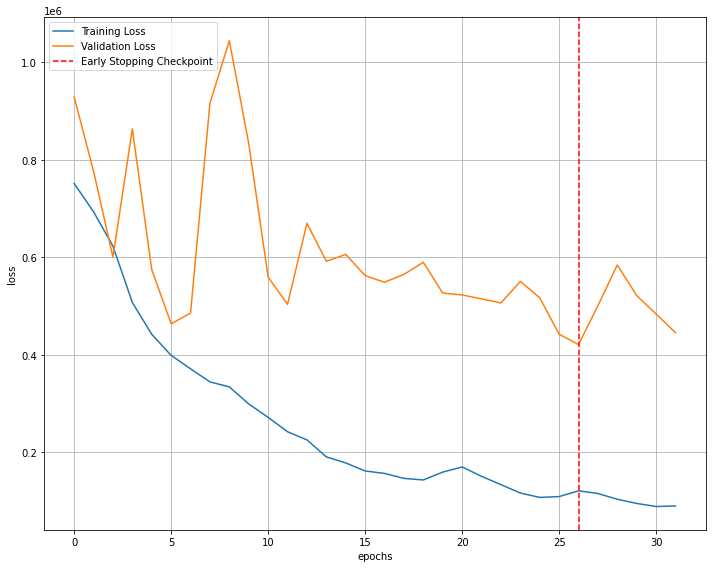

Epoch 32: train loss 90173.08266543203 val loss 445451.0726255136
in training loop, epoch 33, step 0, the loss is 61305.796875
in training loop, epoch 33, step 1, the loss is 42876.62109375
in training loop, epoch 33, step 2, the loss is 36488.1796875
in training loop, epoch 33, step 3, the loss is 39831.875
in training loop, epoch 33, step 4, the loss is 69916.90625
in training loop, epoch 33, step 5, the loss is 69544.515625
in training loop, epoch 33, step 6, the loss is 35692.828125
in training loop, epoch 33, step 7, the loss is 48701.09375
in training loop, epoch 33, step 8, the loss is 59253.58203125
in training loop, epoch 33, step 9, the loss is 79945.25
in training loop, epoch 33, step 10, the loss is 112172.2265625
in training loop, epoch 33, step 11, the loss is 48618.53125
in training loop, epoch 33, step 12, the loss is 59492.41796875
in training loop, epoch 33, step 13, the loss is 65197.390625
in training loop, epoch 33, step 14, the loss is 62369.5703125
in training lo

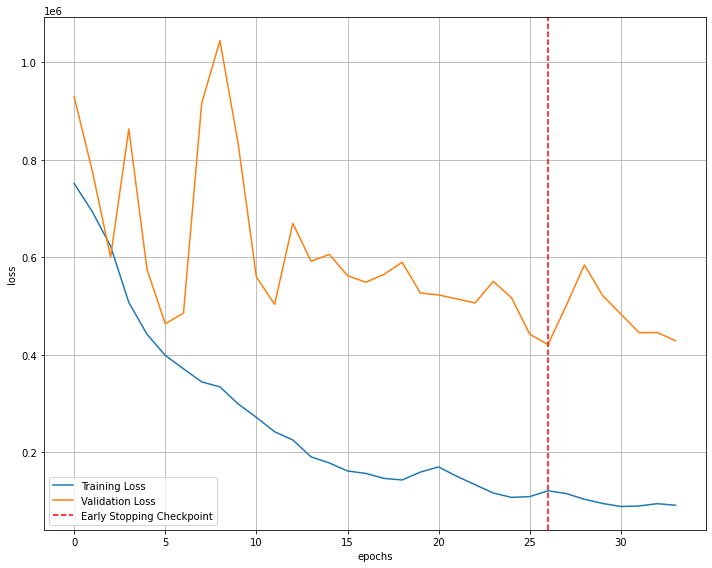

Epoch 34: train loss 91717.56501338397 val loss 429018.8491813994
in training loop, epoch 35, step 0, the loss is 38234.58984375
in training loop, epoch 35, step 1, the loss is 40649.125
in training loop, epoch 35, step 2, the loss is 61299.0234375
in training loop, epoch 35, step 3, the loss is 95494.390625
in training loop, epoch 35, step 4, the loss is 84344.0859375
in training loop, epoch 35, step 5, the loss is 64518.9140625
in training loop, epoch 35, step 6, the loss is 75588.578125
in training loop, epoch 35, step 7, the loss is 77425.1015625
in training loop, epoch 35, step 8, the loss is 90820.65625
in training loop, epoch 35, step 9, the loss is 72641.875
in training loop, epoch 35, step 10, the loss is 117173.625
in training loop, epoch 35, step 11, the loss is 123230.3828125
in training loop, epoch 35, step 12, the loss is 76689.2890625
in training loop, epoch 35, step 13, the loss is 58851.5703125
in training loop, epoch 35, step 14, the loss is 75526.109375
in training l

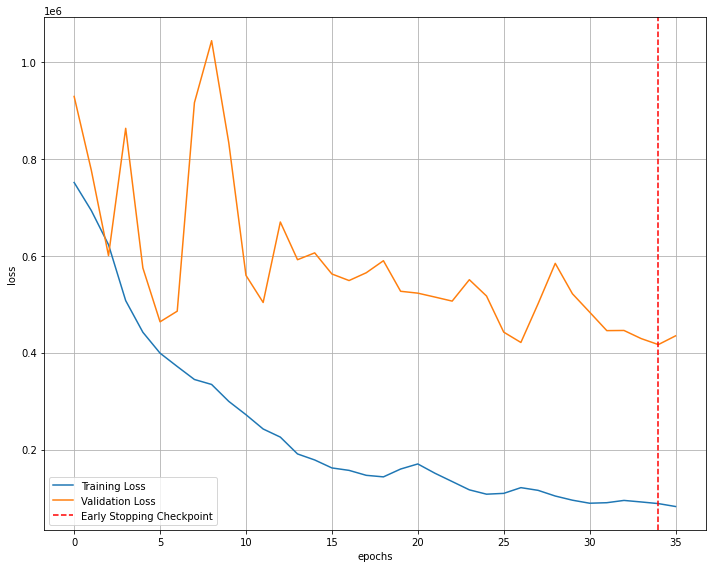

Epoch 36: train loss 82326.13033607756 val loss 434610.4544225442
in training loop, epoch 37, step 0, the loss is 36708.25
in training loop, epoch 37, step 1, the loss is 34586.06640625
in training loop, epoch 37, step 2, the loss is 33750.3828125
in training loop, epoch 37, step 3, the loss is 42197.2734375
in training loop, epoch 37, step 4, the loss is 49987.08203125
in training loop, epoch 37, step 5, the loss is 39418.4921875
in training loop, epoch 37, step 6, the loss is 26682.06640625
in training loop, epoch 37, step 7, the loss is 56903.81640625
in training loop, epoch 37, step 8, the loss is 28250.91796875
in training loop, epoch 37, step 9, the loss is 46171.046875
in training loop, epoch 37, step 10, the loss is 31945.4765625
in training loop, epoch 37, step 11, the loss is 52425.6328125
in training loop, epoch 37, step 12, the loss is 29817.46484375
in training loop, epoch 37, step 13, the loss is 33514.6171875
in training loop, epoch 37, step 14, the loss is 40085.3359375

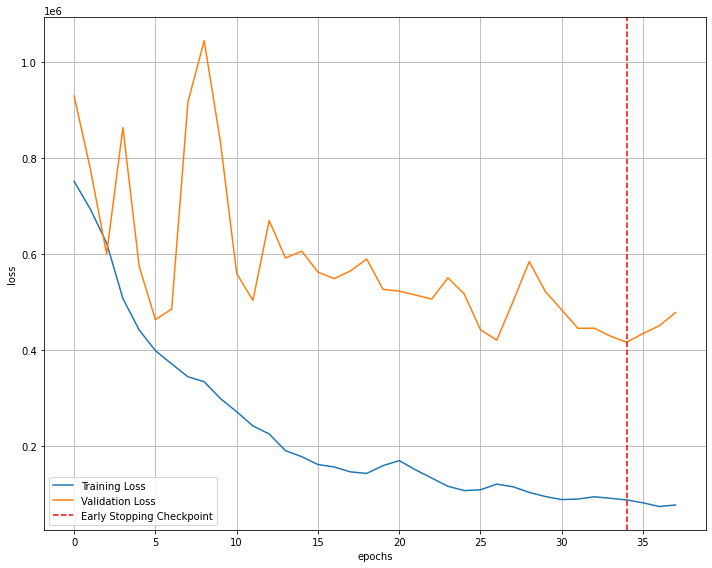

Epoch 38: train loss 77788.4911350691 val loss 478268.03102434013
in training loop, epoch 39, step 0, the loss is 38713.4609375
in training loop, epoch 39, step 1, the loss is 56575.265625
in training loop, epoch 39, step 2, the loss is 35209.4140625
in training loop, epoch 39, step 3, the loss is 98999.5390625
in training loop, epoch 39, step 4, the loss is 59682.24609375
in training loop, epoch 39, step 5, the loss is 106001.1953125
in training loop, epoch 39, step 6, the loss is 54076.0
in training loop, epoch 39, step 7, the loss is 105445.171875
in training loop, epoch 39, step 8, the loss is 74368.875
in training loop, epoch 39, step 9, the loss is 43632.50390625
in training loop, epoch 39, step 10, the loss is 90422.46875
in training loop, epoch 39, step 11, the loss is 34701.84375
in training loop, epoch 39, step 12, the loss is 38176.140625
in training loop, epoch 39, step 13, the loss is 50946.66015625
in training loop, epoch 39, step 14, the loss is 52098.203125
in training 

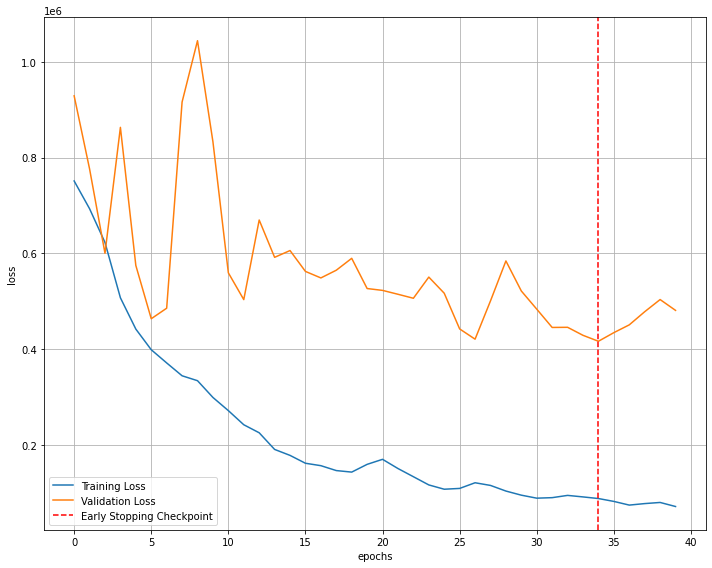

Epoch 40: train loss 71695.03984063744 val loss 481107.90927695466
in training loop, epoch 41, step 0, the loss is 19792.22265625
in training loop, epoch 41, step 1, the loss is 41552.64453125
in training loop, epoch 41, step 2, the loss is 54075.375
in training loop, epoch 41, step 3, the loss is 88484.96875
in training loop, epoch 41, step 4, the loss is 90105.875
in training loop, epoch 41, step 5, the loss is 61742.671875
in training loop, epoch 41, step 6, the loss is 97820.0
in training loop, epoch 41, step 7, the loss is 58095.5703125
in training loop, epoch 41, step 8, the loss is 65775.4375
in training loop, epoch 41, step 9, the loss is 49390.875
in training loop, epoch 41, step 10, the loss is 51633.4609375
in training loop, epoch 41, step 11, the loss is 69968.515625
in training loop, epoch 41, step 12, the loss is 28473.08203125
in training loop, epoch 41, step 13, the loss is 36975.30859375
in training loop, epoch 41, step 14, the loss is 35065.84765625
in training loop, 

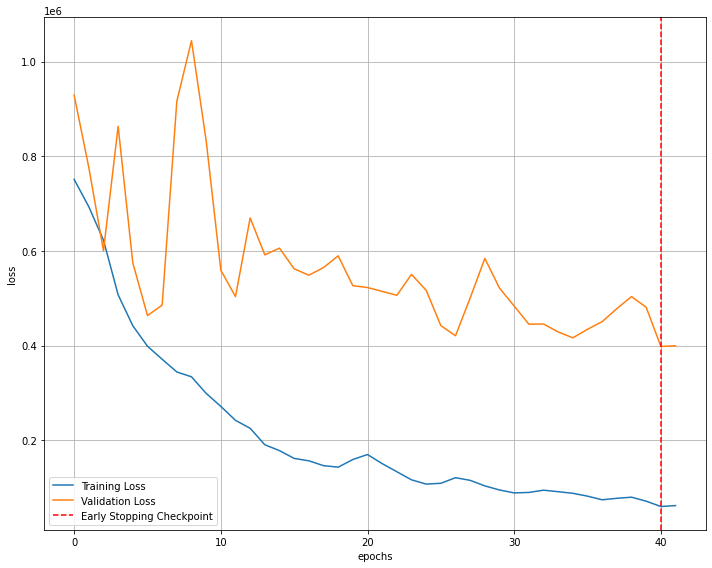

Epoch 42: train loss 62381.87248467069 val loss 399796.8577958673
in training loop, epoch 43, step 0, the loss is 33562.71875
in training loop, epoch 43, step 1, the loss is 31190.91796875
in training loop, epoch 43, step 2, the loss is 37386.03125
in training loop, epoch 43, step 3, the loss is 57486.16015625
in training loop, epoch 43, step 4, the loss is 41487.2578125
in training loop, epoch 43, step 5, the loss is 37878.03125
in training loop, epoch 43, step 6, the loss is 65260.08984375
in training loop, epoch 43, step 7, the loss is 53925.828125
in training loop, epoch 43, step 8, the loss is 48353.078125
in training loop, epoch 43, step 9, the loss is 32508.5390625
in training loop, epoch 43, step 10, the loss is 60798.109375
in training loop, epoch 43, step 11, the loss is 37933.140625
in training loop, epoch 43, step 12, the loss is 61887.05078125
in training loop, epoch 43, step 13, the loss is 45696.5
in training loop, epoch 43, step 14, the loss is 53186.59375
in training l

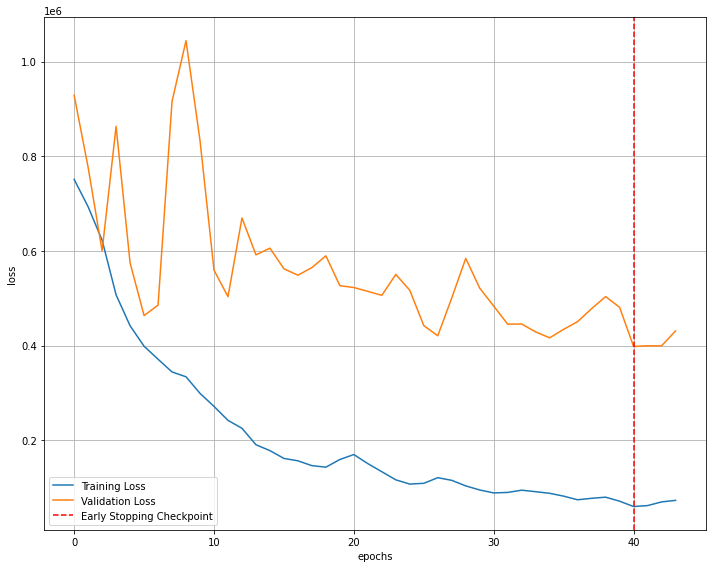

Epoch 44: train loss 73424.4738156748 val loss 431071.63577136764
in training loop, epoch 45, step 0, the loss is 41764.8828125
in training loop, epoch 45, step 1, the loss is 43257.515625
in training loop, epoch 45, step 2, the loss is 34946.2578125
in training loop, epoch 45, step 3, the loss is 36946.4453125
in training loop, epoch 45, step 4, the loss is 39451.9140625
in training loop, epoch 45, step 5, the loss is 215019.78125
in training loop, epoch 45, step 6, the loss is 30174.93359375
in training loop, epoch 45, step 7, the loss is 47224.703125
in training loop, epoch 45, step 8, the loss is 50974.5546875
in training loop, epoch 45, step 9, the loss is 34628.828125
in training loop, epoch 45, step 10, the loss is 71201.46875
in training loop, epoch 45, step 11, the loss is 50342.8515625
in training loop, epoch 45, step 12, the loss is 47668.4453125
in training loop, epoch 45, step 13, the loss is 51525.2109375
in training loop, epoch 45, step 14, the loss is 71296.5703125
in t

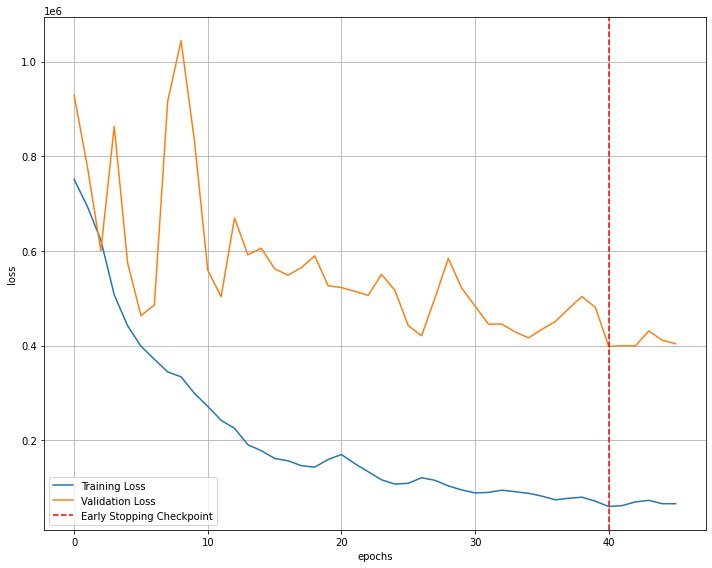

Epoch 46: train loss 66253.2338400305 val loss 404211.1559212369
in training loop, epoch 47, step 0, the loss is 75869.78125
in training loop, epoch 47, step 1, the loss is 76747.625
in training loop, epoch 47, step 2, the loss is 86419.96875
in training loop, epoch 47, step 3, the loss is 128172.0390625
in training loop, epoch 47, step 4, the loss is 66391.71875
in training loop, epoch 47, step 5, the loss is 76802.25
in training loop, epoch 47, step 6, the loss is 53699.1640625
in training loop, epoch 47, step 7, the loss is 57611.3515625
in training loop, epoch 47, step 8, the loss is 69325.375
in training loop, epoch 47, step 9, the loss is 34221.390625
in training loop, epoch 47, step 10, the loss is 62660.15625
in training loop, epoch 47, step 11, the loss is 32611.501953125
in training loop, epoch 47, step 12, the loss is 29753.546875
in training loop, epoch 47, step 13, the loss is 46023.46875
in training loop, epoch 47, step 14, the loss is 34311.296875
in training loop, epoch

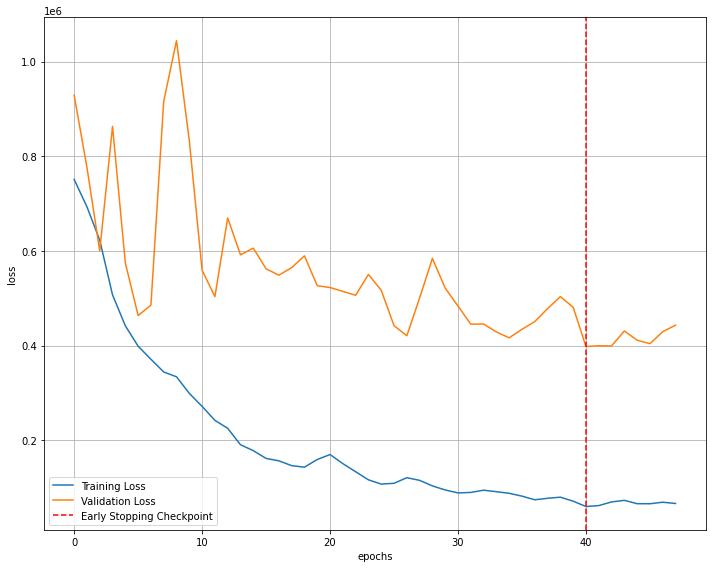

Epoch 48: train loss 66833.40493689306 val loss 443394.1319059699
in training loop, epoch 49, step 0, the loss is 43271.828125
in training loop, epoch 49, step 1, the loss is 48290.9296875
in training loop, epoch 49, step 2, the loss is 60895.328125
in training loop, epoch 49, step 3, the loss is 83127.7265625
in training loop, epoch 49, step 4, the loss is 85350.75
in training loop, epoch 49, step 5, the loss is 102157.8125
in training loop, epoch 49, step 6, the loss is 52397.48828125
in training loop, epoch 49, step 7, the loss is 48817.3828125
in training loop, epoch 49, step 8, the loss is 45724.40234375
in training loop, epoch 49, step 9, the loss is 40836.5
in training loop, epoch 49, step 10, the loss is 59978.37890625
in training loop, epoch 49, step 11, the loss is 54911.48828125
in training loop, epoch 49, step 12, the loss is 69147.890625
in training loop, epoch 49, step 13, the loss is 114101.1875
in training loop, epoch 49, step 14, the loss is 48759.01171875
in training 

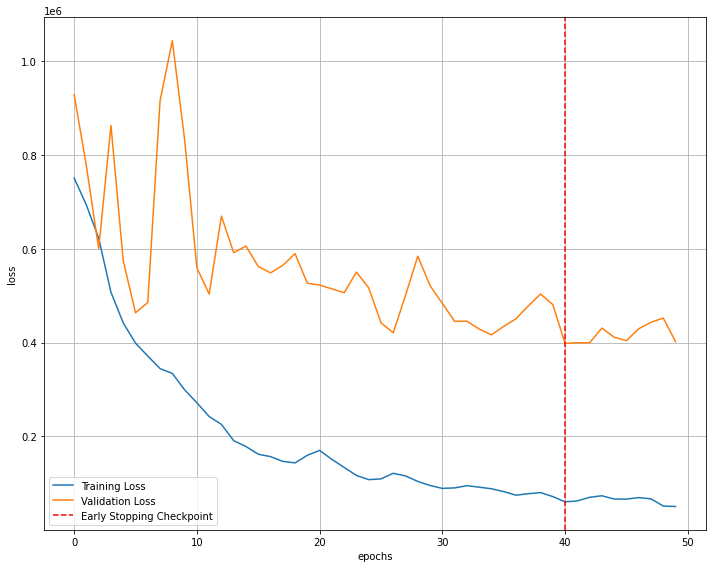

Epoch 50: train loss 50469.10324716758 val loss 402288.24534284737
in training loop, epoch 51, step 0, the loss is 60165.46484375
in training loop, epoch 51, step 1, the loss is 39889.09375
in training loop, epoch 51, step 2, the loss is 30445.228515625
in training loop, epoch 51, step 3, the loss is 32998.9765625
in training loop, epoch 51, step 4, the loss is 33000.73046875
in training loop, epoch 51, step 5, the loss is 37761.97265625
in training loop, epoch 51, step 6, the loss is 54049.5703125
in training loop, epoch 51, step 7, the loss is 60657.296875
in training loop, epoch 51, step 8, the loss is 80176.5859375
in training loop, epoch 51, step 9, the loss is 127869.625
in training loop, epoch 51, step 10, the loss is 112701.046875
in training loop, epoch 51, step 11, the loss is 130044.1171875
in training loop, epoch 51, step 12, the loss is 56857.3203125
in training loop, epoch 51, step 13, the loss is 43262.5078125
in training loop, epoch 51, step 14, the loss is 41409.90625


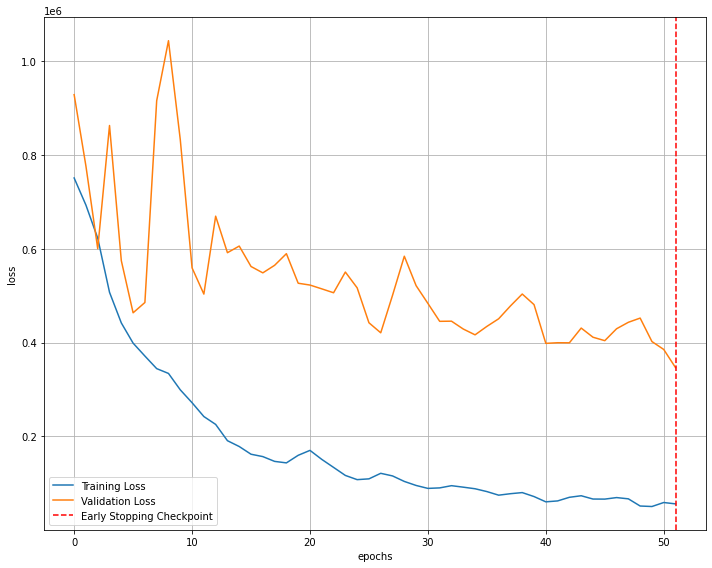

Epoch 52: train loss 56073.80666688714 val loss 346697.7729064212
in training loop, epoch 53, step 0, the loss is 28098.625
in training loop, epoch 53, step 1, the loss is 30701.32421875
in training loop, epoch 53, step 2, the loss is 40032.4296875
in training loop, epoch 53, step 3, the loss is 61612.3671875
in training loop, epoch 53, step 4, the loss is 39164.4921875
in training loop, epoch 53, step 5, the loss is 55533.0625
in training loop, epoch 53, step 6, the loss is 89375.7421875
in training loop, epoch 53, step 7, the loss is 77091.59375
in training loop, epoch 53, step 8, the loss is 44841.87109375
in training loop, epoch 53, step 9, the loss is 72209.578125
in training loop, epoch 53, step 10, the loss is 37525.609375
in training loop, epoch 53, step 11, the loss is 74883.8125
in training loop, epoch 53, step 12, the loss is 26955.248046875
in training loop, epoch 53, step 13, the loss is 23608.9765625
in training loop, epoch 53, step 14, the loss is 20530.8515625
in traini

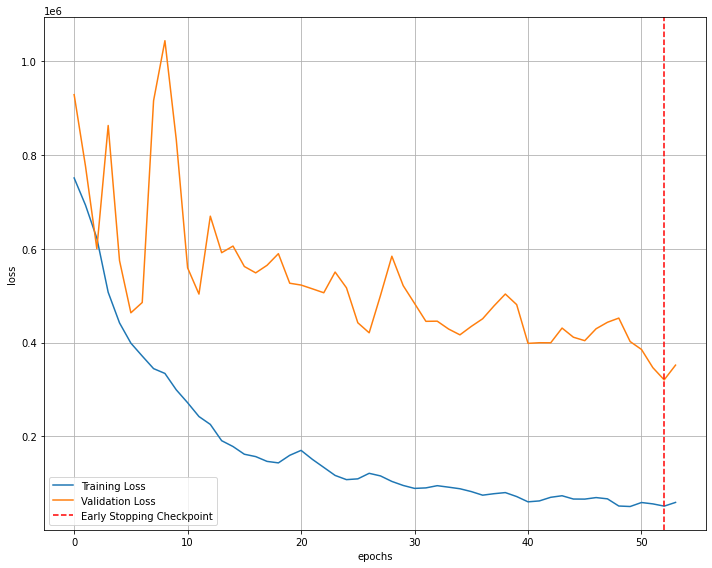

Epoch 54: train loss 59197.20828210595 val loss 352027.68390305963
in training loop, epoch 55, step 0, the loss is 30735.625
in training loop, epoch 55, step 1, the loss is 67836.921875
in training loop, epoch 55, step 2, the loss is 34080.92578125
in training loop, epoch 55, step 3, the loss is 53007.9609375
in training loop, epoch 55, step 4, the loss is 50525.65625
in training loop, epoch 55, step 5, the loss is 63682.3671875
in training loop, epoch 55, step 6, the loss is 66012.21875
in training loop, epoch 55, step 7, the loss is 37049.2421875
in training loop, epoch 55, step 8, the loss is 63409.9375
in training loop, epoch 55, step 9, the loss is 41995.79296875
in training loop, epoch 55, step 10, the loss is 59821.109375
in training loop, epoch 55, step 11, the loss is 49991.1015625
in training loop, epoch 55, step 12, the loss is 23869.67578125
in training loop, epoch 55, step 13, the loss is 20681.892578125
in training loop, epoch 55, step 14, the loss is 30143.0546875
in tra

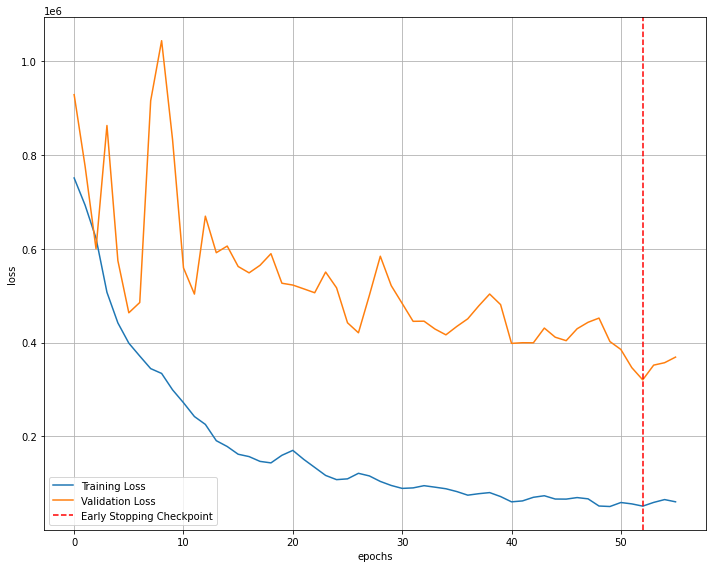

Epoch 56: train loss 60501.504811807456 val loss 369113.17134197586
in training loop, epoch 57, step 0, the loss is 62827.0390625
in training loop, epoch 57, step 1, the loss is 47772.91796875
in training loop, epoch 57, step 2, the loss is 31515.14453125
in training loop, epoch 57, step 3, the loss is 30709.384765625
in training loop, epoch 57, step 4, the loss is 24173.046875
in training loop, epoch 57, step 5, the loss is 22736.970703125
in training loop, epoch 57, step 6, the loss is 24975.453125
in training loop, epoch 57, step 7, the loss is 26778.32421875
in training loop, epoch 57, step 8, the loss is 26797.98828125
in training loop, epoch 57, step 9, the loss is 26298.37890625
in training loop, epoch 57, step 10, the loss is 40218.7109375
in training loop, epoch 57, step 11, the loss is 30426.55078125
in training loop, epoch 57, step 12, the loss is 27900.41015625
in training loop, epoch 57, step 13, the loss is 29698.265625
in training loop, epoch 57, step 14, the loss is 332

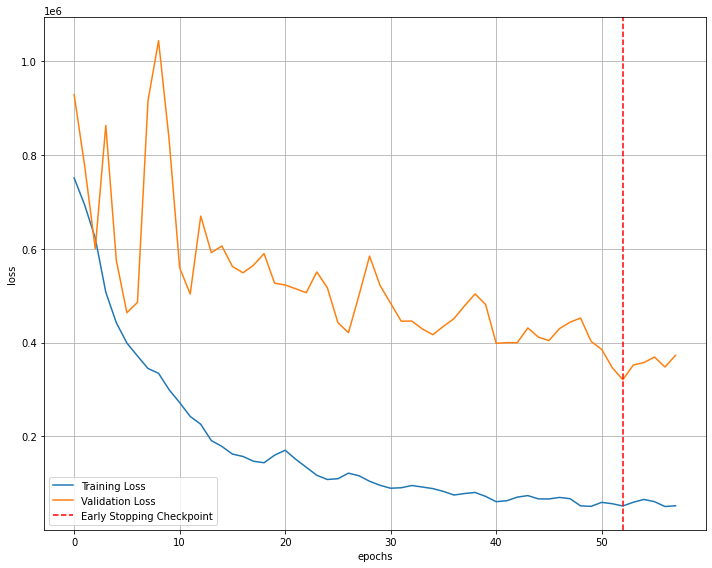

Epoch 58: train loss 51668.498673275644 val loss 372662.0825068865
in training loop, epoch 59, step 0, the loss is 28393.25390625
in training loop, epoch 59, step 1, the loss is 24811.08203125
in training loop, epoch 59, step 2, the loss is 26236.3203125
in training loop, epoch 59, step 3, the loss is 32556.046875
in training loop, epoch 59, step 4, the loss is 19173.875
in training loop, epoch 59, step 5, the loss is 26342.3671875
in training loop, epoch 59, step 6, the loss is 23970.8515625
in training loop, epoch 59, step 7, the loss is 40417.4921875
in training loop, epoch 59, step 8, the loss is 39023.57421875
in training loop, epoch 59, step 9, the loss is 37182.1015625
in training loop, epoch 59, step 10, the loss is 39205.1953125
in training loop, epoch 59, step 11, the loss is 40616.109375
in training loop, epoch 59, step 12, the loss is 44658.35546875
in training loop, epoch 59, step 13, the loss is 35320.4375
in training loop, epoch 59, step 14, the loss is 22594.2890625
in 

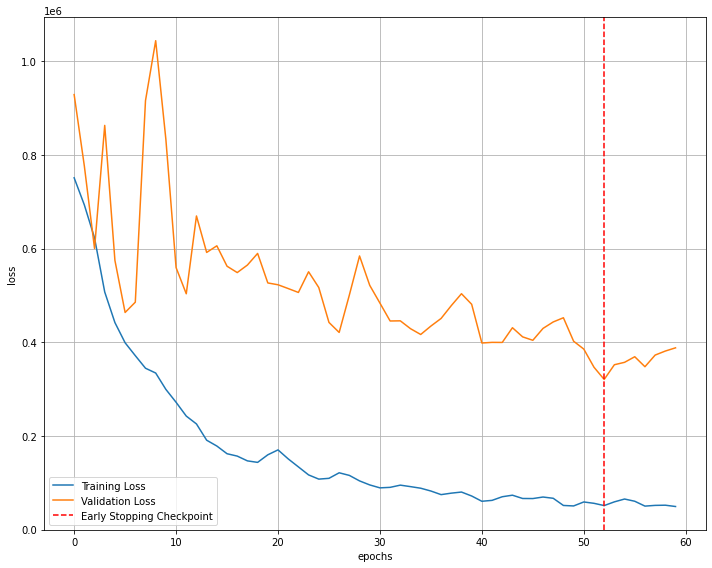

Epoch 60: train loss 49266.05566503517 val loss 388125.8451851773
in training loop, epoch 61, step 0, the loss is 29444.75390625
in training loop, epoch 61, step 1, the loss is 30701.361328125
in training loop, epoch 61, step 2, the loss is 23328.6640625
in training loop, epoch 61, step 3, the loss is 23773.62890625
in training loop, epoch 61, step 4, the loss is 44550.203125
in training loop, epoch 61, step 5, the loss is 19726.634765625
in training loop, epoch 61, step 6, the loss is 24199.962890625
in training loop, epoch 61, step 7, the loss is 20617.9453125
in training loop, epoch 61, step 8, the loss is 23677.98828125
in training loop, epoch 61, step 9, the loss is 26767.234375
in training loop, epoch 61, step 10, the loss is 36494.96875
in training loop, epoch 61, step 11, the loss is 32057.9296875
in training loop, epoch 61, step 12, the loss is 22945.2421875
in training loop, epoch 61, step 13, the loss is 21837.78125
in training loop, epoch 61, step 14, the loss is 26069.6875

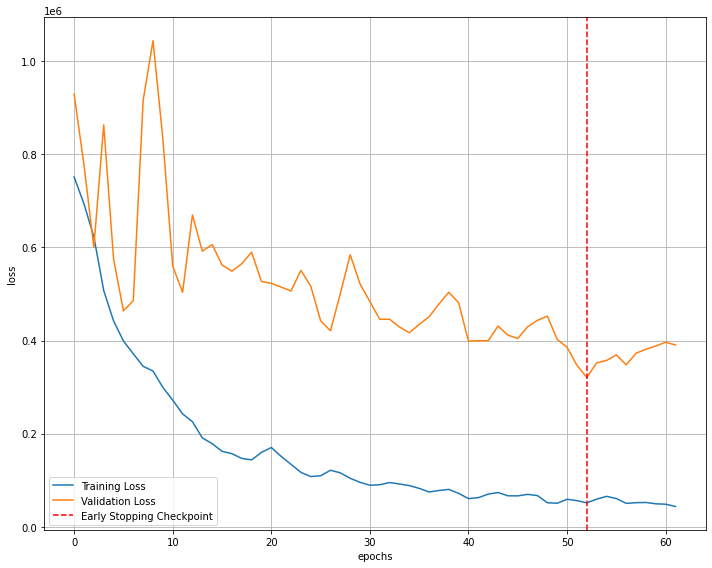

Epoch 62: train loss 43415.977074125374 val loss 390334.9102107196
in training loop, epoch 63, step 0, the loss is 14979.7568359375
in training loop, epoch 63, step 1, the loss is 19124.193359375
in training loop, epoch 63, step 2, the loss is 16326.140625
in training loop, epoch 63, step 3, the loss is 36013.828125
in training loop, epoch 63, step 4, the loss is 29188.40625
in training loop, epoch 63, step 5, the loss is 35439.1953125
in training loop, epoch 63, step 6, the loss is 27366.91796875
in training loop, epoch 63, step 7, the loss is 41026.08984375
in training loop, epoch 63, step 8, the loss is 38356.359375
in training loop, epoch 63, step 9, the loss is 18460.359375
in training loop, epoch 63, step 10, the loss is 29131.466796875
in training loop, epoch 63, step 11, the loss is 24900.21484375
in training loop, epoch 63, step 12, the loss is 15555.509765625
in training loop, epoch 63, step 13, the loss is 15138.72265625
in training loop, epoch 63, step 14, the loss is 21913

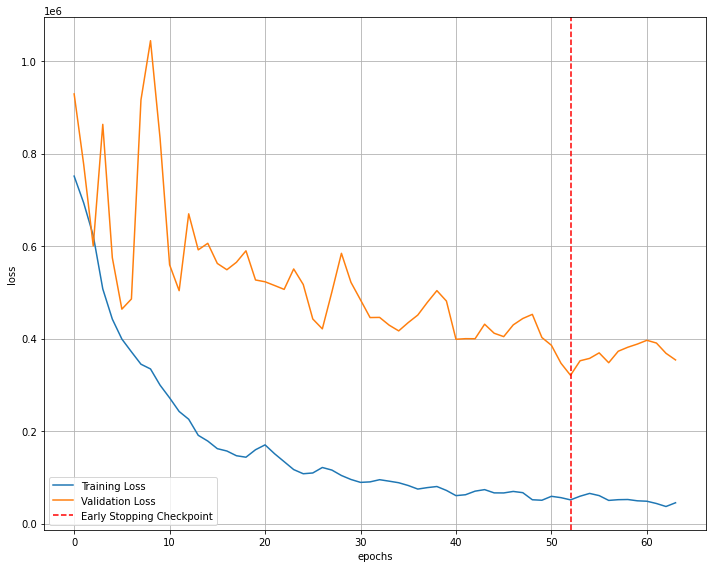

Epoch 64: train loss 45031.95478535078 val loss 353826.0749910514
in training loop, epoch 65, step 0, the loss is 67288.3515625
in training loop, epoch 65, step 1, the loss is 28636.470703125
in training loop, epoch 65, step 2, the loss is 30512.650390625
in training loop, epoch 65, step 3, the loss is 22901.5078125
in training loop, epoch 65, step 4, the loss is 33912.28125
in training loop, epoch 65, step 5, the loss is 29536.828125
in training loop, epoch 65, step 6, the loss is 25965.95703125
in training loop, epoch 65, step 7, the loss is 36831.34375
in training loop, epoch 65, step 8, the loss is 35198.05859375
in training loop, epoch 65, step 9, the loss is 39133.1875
in training loop, epoch 65, step 10, the loss is 55933.1015625
in training loop, epoch 65, step 11, the loss is 78179.8828125
in training loop, epoch 65, step 12, the loss is 77912.7890625
in training loop, epoch 65, step 13, the loss is 59141.11328125
in training loop, epoch 65, step 14, the loss is 73720.734375
i

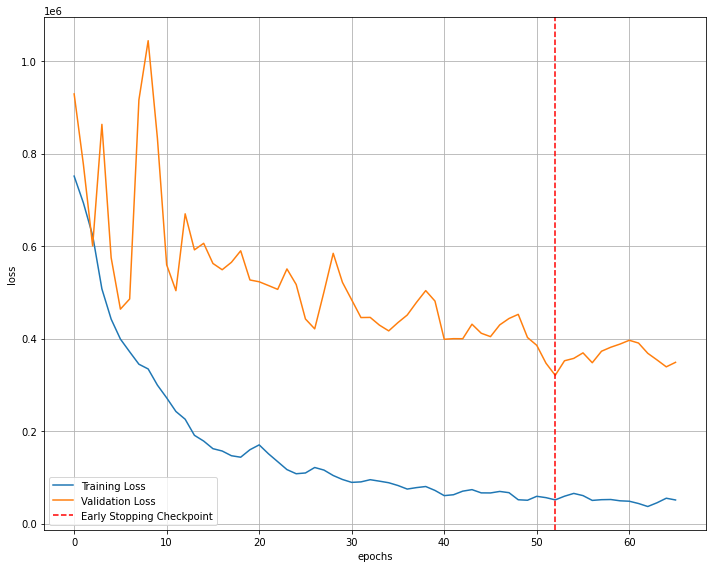

Epoch 66: train loss 51052.41771293731 val loss 348638.1631277624
in training loop, epoch 67, step 0, the loss is 24496.2890625
in training loop, epoch 67, step 1, the loss is 25523.6640625
in training loop, epoch 67, step 2, the loss is 21043.55859375
in training loop, epoch 67, step 3, the loss is 26232.806640625
in training loop, epoch 67, step 4, the loss is 23251.740234375
in training loop, epoch 67, step 5, the loss is 33312.703125
in training loop, epoch 67, step 6, the loss is 29667.966796875
in training loop, epoch 67, step 7, the loss is 42224.25
in training loop, epoch 67, step 8, the loss is 21499.8359375
in training loop, epoch 67, step 9, the loss is 55450.9921875
in training loop, epoch 67, step 10, the loss is 36746.55859375
in training loop, epoch 67, step 11, the loss is 35386.55859375
in training loop, epoch 67, step 12, the loss is 36910.22265625
in training loop, epoch 67, step 13, the loss is 46734.54296875
in training loop, epoch 67, step 14, the loss is 54410.08

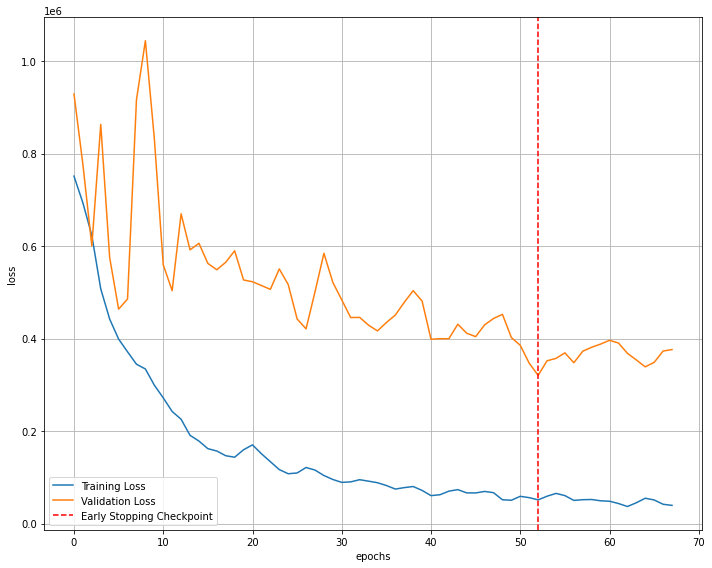

Epoch 68: train loss 39359.185880501434 val loss 376203.4236841696
in training loop, epoch 69, step 0, the loss is 35338.38671875
in training loop, epoch 69, step 1, the loss is 42152.1171875
in training loop, epoch 69, step 2, the loss is 52847.4609375
in training loop, epoch 69, step 3, the loss is 50607.296875
in training loop, epoch 69, step 4, the loss is 50611.73046875
in training loop, epoch 69, step 5, the loss is 58751.921875
in training loop, epoch 69, step 6, the loss is 46978.453125
in training loop, epoch 69, step 7, the loss is 42020.8828125
in training loop, epoch 69, step 8, the loss is 50433.5625
in training loop, epoch 69, step 9, the loss is 80110.5625
in training loop, epoch 69, step 10, the loss is 103386.375
in training loop, epoch 69, step 11, the loss is 71357.796875
in training loop, epoch 69, step 12, the loss is 64017.1015625
in training loop, epoch 69, step 13, the loss is 46105.7734375
in training loop, epoch 69, step 14, the loss is 46537.20703125
in train

In [ ]:
import copy
import math
import numpy as np

import torch

class TrainingWrapper:

  def __init__(self, config, training_loader, test_loader, device):
    self.config = config
    self.training_loader = training_loader
    self.test_loader = test_loader
    self.device = device
    self.model = RecurrentAutoencoder(self.config.seq_len, self.config.input_dim, self.config.embedding_dim, device=self.device)
    self.model = self.model.to(self.device)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.lr)
    self.criterion = self.config.loss_function.to(self.device)
    self.history = dict(train=[], val=[])
    self.best_model_wts = copy.deepcopy(self.model.state_dict())
    self.best_loss = 10000.0
    print(self.config.base_dir + self.config.model_file)
    torch.save(self.model.state_dict(), self.config.base_dir + self.config.model_file)

  def combine_images(self, generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image


  def show_reconstruction(self, test_loader, n_images):
    import matplotlib.pyplot as plt
    
    from PIL import Image
    import numpy as np

    self.model.eval()
    for x, _ in self.test_loader:
        x = x[:min(n_images, x.size(0))].to(self,device)
        _, x_recon = self.model(x)
        data = np.concatenate([x.data.cpu(), x_recon.data.cpu()])
        img = self.combine_images(np.transpose(data, [0, 2, 3, 1]))
        image = img * 255
        Image.fromarray(image.astype(np.uint8)).save(self.config.base_dir + "/real_and_recon.png")
        print()
        print('Reconstructed images are saved to %s/real_and_recon.png' % self.config.base_dir)
        print('-' * 70)
        plt.imshow(plt.imread(self.config.base_dir + "/real_and_recon.png", ))
        plt.show()
        break

  def visualizeTraining(self, epoch, trn_losses, tst_losses, save_dir):
    # visualize the loss as the network trained
    print("trn_losses..... ",trn_losses)
    print("tst_losses..... ",tst_losses)
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(0, len(trn_losses)), trn_losses, label='Training Loss')
    if tst_losses:
      plt.plot(range(0, len(tst_losses)), tst_losses, label='Validation Loss')
    minposs = tst_losses.index(min(tst_losses))
    plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')


    plt.xlabel('epochs')
    plt.ylabel('loss')
    # plt.ylim(0, 0.5)  # consistent scale
    # plt.xlim(0, len(trn_losses))  # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(save_dir , 'loss_plot_{}.png'.format(epoch)), bbox_inches='tight')

  def train(self):
    for epoch in range(1, self.config.n_epochs + 1):
      self.model = self.model.train()
      train_losses = []

      for i, (x, y) in enumerate(self.training_loader):
        self.optimizer.zero_grad()
        x = x.to(self.device)
        y = y.to(self.device)

        output = self.model(x)
        loss = self.criterion(output, x)

        loss.backward()
        self.optimizer.step()
        train_losses.append(loss.item())
        print("in training loop, epoch {}, step {}, the loss is {}".format(epoch, i, loss.item()))

      val_losses = []
      self.model = self.model.eval()
      with torch.no_grad():
        for i, (x, y) in enumerate(self.test_loader):
          x = x.to(device)
          y = y.to(device)
          output = self.model(x)
          loss = self.criterion(output, x)
          val_losses.append(loss.item())
      train_loss = np.mean(train_losses)
      val_loss = np.mean(val_losses)
      self.history['train'].append(train_loss)
      self.history['val'].append(val_loss)
      if val_loss < self.best_loss:
        self.best_loss = val_loss
        self.best_model_wts = copy.deepcopy(self.model.state_dict())
      if epoch % 2 == 0:
        self.visualizeTraining(epoch, trn_losses= self.history['train'], tst_losses=self.history['val'], save_dir=self.config.base_dir + "/results")
        torch.save(self.model.state_dict(), self.config.base_dir + self.config.checkpoint_model_file)
      print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    self.model.load_state_dict(self.best_model_wts)
    torch.save(self.model.state_dict(), self.config.base_dir + self.config.model_file)
    return self.model.eval(), self.history

  
class TestingWrapper:
  def __init__(self, config, device):
    self.config = config
    self.device = device
    self.model = RecurrentAutoencoder(self.config.seq_len, self.config.input_dim, self.config.embedding_dim, device=self.device)
    PATH = self.config.base_dir + self.config.model_file
    print(PATH)
    self.model.load_state_dict(torch.load(PATH, map_location=self.device))
    self.model = self.model.to(self.device)

  def combine_images(self, generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image


  def show_reconstruction(self, test_loader, n_images):
    import matplotlib.pyplot as plt
    
    from PIL import Image
    import numpy as np

    self.model.eval()
    for x, _ in test_loader:
      x = x[:min(n_images, x.size(0))].to(self.device)
      x_recon = self.model(x)
      data = np.concatenate([x.data.cpu(), x_recon.data.cpu()])
      img = self.combine_images(np.transpose(data, [0, 2, 3, 1]))
      image = img * 255
      Image.fromarray(image.astype(np.uint8)).save(self.config.base_dir + "/real_and_recon.png")
      print()
      print('Reconstructed images are saved to %s/real_and_recon.png' % self.config.base_dir)
      print('-' * 70)
      plt.imshow(plt.imread(self.config.base_dir + "/real_and_recon.png", ))
      plt.show()
      break



mode = 'train'
data = "mel"
#data = "mnist"
config = configeration()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed=1234):
  import random
  import os
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True

seed_everything()

if data=="mnist":
  config.seq_len = 28
  config.input_dim = 28
  config.embedding_dim = 64
  config.batch_size = 100
  config.base_dir = "/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST"
  config.model_file = "/models/mnist.pkl"
  config.results_dir = os.path.join(config.base_dir, "./results")
  
  #train_loader, test_loader = load_mnist(os.path.join(config.base_dir, "./data"), download=False, batch_size=config.batch_size)
  train_df = pd.read_csv("/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST/data/MNIST/mnist_train.csv")
  test_df = pd.read_csv("/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST/data/MNIST/mnist_test.csv")

  train_dataset = CustomDatasetMNIST(train_df)
  test_data_set = CustomDatasetMNIST(test_df)

  train_loader = DataLoader(train_dataset,
                                  batch_size=config.batch_size,
                                  sampler=SequentialSampler(train_dataset), drop_last=False)

  test_loader = DataLoader(test_data_set,
                                batch_size=config.batch_size,
                                sampler=SequentialSampler(test_data_set), drop_last=False)

else:
  train_data = files
  labels = [1] * len(files)

  train_dataset = CustomDatasetMel(train_data, labels)
  test_data_set = CustomDatasetMel(train_data, labels)

  train_loader = DataLoader(train_dataset,
                                  batch_size=config.batch_size,
                                  sampler=SequentialSampler(train_dataset), drop_last=False)

  test_loader = DataLoader(test_data_set,
                                batch_size=config.batch_size,
                                sampler=SequentialSampler(test_data_set), drop_last=False)


if mode=="train":
  trainingWrapper = TrainingWrapper(config=config, training_loader=train_loader, test_loader=test_loader, device=device)
  model, history = trainingWrapper.train()

  if data=="mnist":
    #trainingWrapper.show_reconstruction(test_loader=test_loader, n_images=50)
    pass

elif mode=='test':
  testingWrapper = TestingWrapper(config=config, device=device)
  testingWrapper.show_reconstruction(test_loader=test_loader, n_images=50)



In [ ]:
import numpy as np 
from PIL import Image

model = RecurrentAutoencoder(28, 28, 64, device=device)
PATH = "/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MNIST_TEST/models/mnist.pkl"
print(PATH)
model.load_state_dict(torch.load(PATH, map_location=device))
model = model.to(device)

array = np.array(train_df.iloc[0][1:].tolist())

array = np.reshape(array, (28, 28))
array = torch.tensor(array,dtype=torch.float)
array = array.unsqueeze(dim=0)
array = array.to(device)
print(array)
array = model(array)
print(array)
array = array.squeeze(dim=0)
data = Image.fromarray(np.uint8(array.cpu().detach().numpy())).convert('RGB')
data

trn_losses.....  [8, 4, 5]
tst_losses.....  [8, 4, 5]


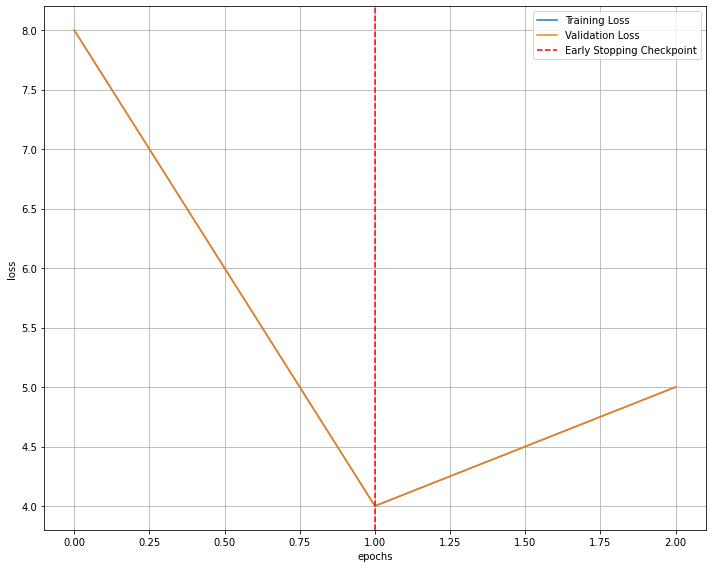

In [25]:
def visualizeTrainingTest(epoch, trn_losses, tst_losses, save_dir):
    # visualize the loss as the network trained
    print("trn_losses..... ",trn_losses)
    print("tst_losses..... ",tst_losses)
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 8))
    plt.plot(range(0, len(trn_losses)), trn_losses, label='Training Loss')
    if tst_losses:
      plt.plot(range(0, len(tst_losses)), tst_losses, label='Validation Loss')
    
    minposs = tst_losses.index(min(tst_losses))
    plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')


    plt.xlabel('epochs')
    plt.ylabel('loss')
    # plt.ylim(0, 0.5)  # consistent scale
    # plt.xlim(0, len(trn_losses))  # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(10, 8))
# trn_losses = [8,4,5]
# plt.plot(range(0, len(trn_losses)), trn_losses, label='Training Loss')
# plt.show()

trn_losses = [8,4,5]

visualizeTrainingTest(3,trn_losses,trn_losses,'/content/drive/My Drive/vajra/LSTM_AUTO_ENC_V1/MEL/Indian/models/')